In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc


In [3]:
from imblearn.over_sampling import SMOTE
from collections import Counter


In [4]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier


In [5]:
# 🔹 Load dataset (Update filename if needed)
df = pd.read_csv("/content/credit_risk_dataset.csv")


In [6]:
# 🔹 Display basic info
print(df.head())
print(df.info())

   person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59                         Y                           3  


In [7]:
# 🔹 Check for missing values
print("\nMissing values before imputation:")
print(df.isnull().sum())



Missing values before imputation:
person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64


In [8]:
# 🔹 Handle missing values using median imputation
imputer = SimpleImputer(strategy="median")
df["person_emp_length"] = imputer.fit_transform(df[["person_emp_length"]])
df["loan_int_rate"] = imputer.fit_transform(df[["loan_int_rate"]])


In [9]:
# 🔹 Verify missing values are handled
print("\nMissing values after imputation:")
print(df.isnull().sum())  # Should print 0 for all columns


Missing values after imputation:
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64


In [10]:
# 🔹 Select features (X) and target variable (y)
X = df.drop(columns=['loan_status'])  # Exclude target variable
y = df['loan_status']


In [11]:
# 🔹 One-hot encode categorical features
X = pd.get_dummies(X, drop_first=True)  # Convert categorical variables to dummy variables


In [12]:
# 🔹 Check for missing values after encoding
print("\nMissing values after encoding:")
print(X.isnull().sum().sum())  # Should be 0


Missing values after encoding:
0


In [13]:
# 🔹 Train-Test Split (before applying SMOTE)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# 🔹 Apply SMOTE to balance training data only (NOT test data)
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [15]:
# 🔹 Check class distribution after SMOTE
print("\nClass distribution after SMOTE:", Counter(y_train_sm))



Class distribution after SMOTE: Counter({0: 20401, 1: 20401})


In [16]:
# 🔹 Scale numerical features (for Logistic Regression)
scaler = StandardScaler()
X_train_sm = scaler.fit_transform(X_train_sm)
X_test = scaler.transform(X_test)


In [17]:
# 🔹 Train the Hybrid Model (XGBoost + Logistic Regression)
scale_pos_weight = sum(y_train_sm == 0) / sum(y_train_sm == 1)  # Adjust for class imbalance in XGBoost


In [18]:
# XGBoost Model
xgb_model = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, eval_metric='logloss')


In [19]:
# Logistic Regression Model
log_reg_model = LogisticRegression(solver='liblinear', random_state=42)


In [20]:
# Hybrid Model using Voting Classifier (Soft Voting)
hybrid_model = VotingClassifier(estimators=[('xgb', xgb_model), ('logreg', log_reg_model)], voting='soft')


In [22]:
# 🔹 Train the Hybrid Model
hybrid_model.fit(X_train_sm, y_train_sm)
print("\n Hybrid Model Training Completed!")



 Hybrid Model Training Completed!


In [23]:
# 🔹 Make Predictions
y_pred = hybrid_model.predict(X_test)
y_pred_prob = hybrid_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC curve

In [25]:
# 🔹 Model Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"\n Model Accuracy: {accuracy:.2%}")



 Model Accuracy: 91.65%


In [26]:
# Classification Report
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))



📊 Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95      5072
           1       0.86      0.74      0.80      1445

    accuracy                           0.92      6517
   macro avg       0.90      0.85      0.87      6517
weighted avg       0.91      0.92      0.91      6517



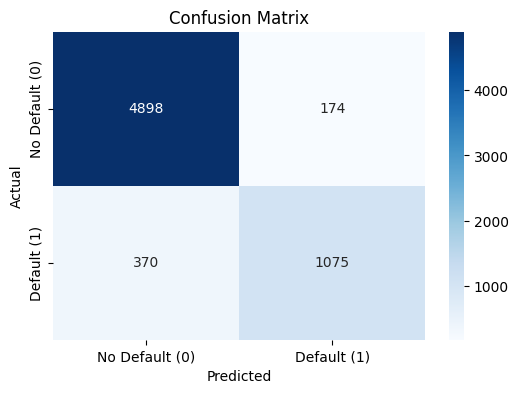

In [27]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Default (0)", "Default (1)"], yticklabels=["No Default (0)", "Default (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


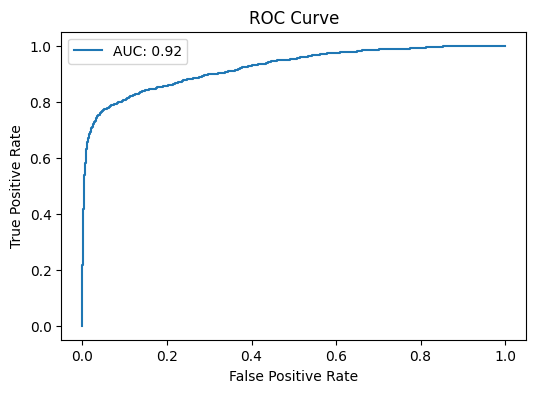

In [28]:
# 🔹 ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC: {auc(fpr, tpr):.2f}')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [29]:
# 🔹 Sample Input for Prediction
sample_input = pd.DataFrame({
    'person_age': [35],
    'person_income': [50000],
    'person_home_ownership': ['RENT'],
    'person_emp_length': [5],
    'loan_intent': ['EDUCATION'],
    'loan_grade': ['B'],
    'loan_amnt': [15000],
    'loan_int_rate': [12.5],
    'loan_percent_income': [0.3],
    'cb_person_default_on_file': ['Y'],
    'cb_person_cred_hist_length': [7]
})


In [30]:

# Apply the same encoding as training data
sample_input_encoded = pd.get_dummies(sample_input)


In [31]:
# Ensure input has the same columns as the training dataset
missing_cols = set(X.columns) - set(sample_input_encoded.columns)
for col in missing_cols:
    sample_input_encoded[col] = 0  # Add missing columns with 0


In [32]:

# Reorder columns to match training set
sample_input_encoded = sample_input_encoded[X.columns]

# Scale input data
sample_input_scaled = scaler.transform(sample_input_encoded)


In [34]:
# 🔹 Predict Loan Default
prediction = hybrid_model.predict(sample_input_scaled)
fraud_probability = hybrid_model.predict_proba(sample_input_scaled)[:, 1][0]

if prediction[0] == 1:
    print("\n Fraudulent Transaction Detected! ")
else:
    print("\n Legitimate Transaction ")

print(f"\n Fraud Probability: {fraud_probability:.2%}")


 Legitimate Transaction 

 Fraud Probability: 33.96%
